In [154]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
def f(x):
    return 3*x**2 - 4*x + 5

In [57]:
f(3.0)

20.0

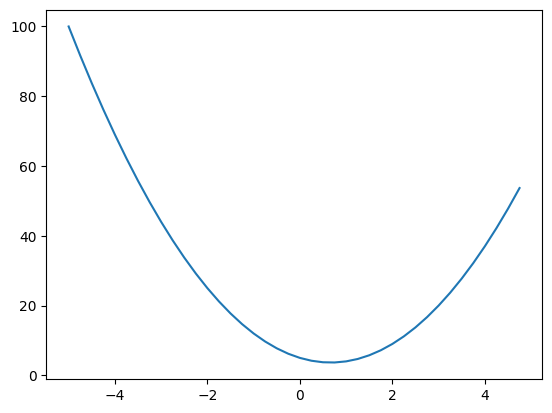

In [58]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [59]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [60]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [61]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
#print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001


In [681]:
class Value:
    
    def __init__(self, data, _children={}, _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, {self, other}, '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, {self, other}, '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floats for now"
        out = Value(self.data**other, {self, }, f'**{other}')
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e' 
d = e + c; d.label = 'd'
f = Value(-3.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-12.0, grad=0.0)

In [683]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [684]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735817905432, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1  + x2w2; x1w1x2w2.label = 'x1w1xx2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

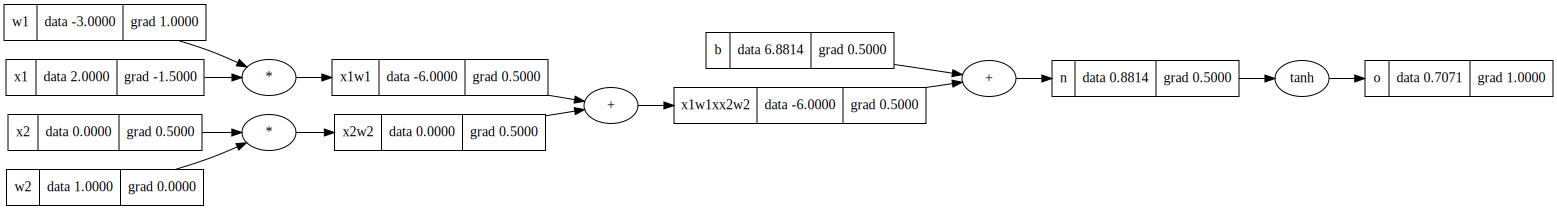

In [685]:
draw_dot(o)

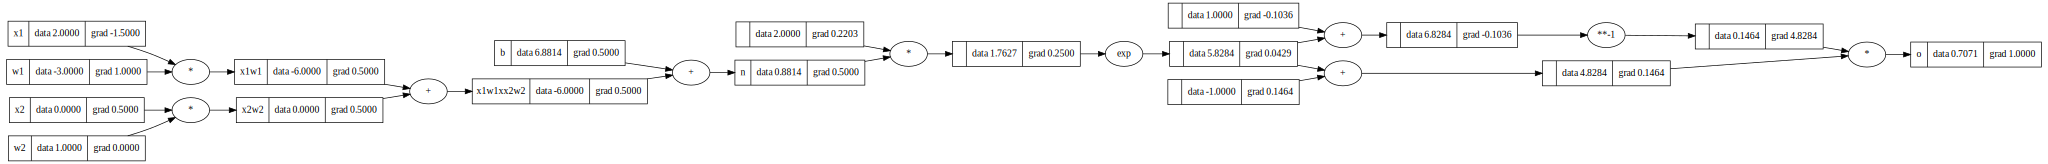

In [686]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735817905432, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1  + x2w2; x1w1x2w2.label = 'x1w1xx2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [795]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x;
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [950]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.0619083656162654, grad=0.0)

In [951]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [969]:
for k in range(20):
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt,yout in zip(ys, ypred))
        
        # backward pass
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
        
        # update
        for p in n.parameters():
            p.data += -0.05 * p.grad
            
        print (k, loss.data)

0 0.0014144694276830418
1 0.001409730061251736
2 0.0014050209775860931
3 0.0014003418928915253
4 0.0013956925268698503
5 0.0013910726026660175
6 0.0013864818468157377
7 0.001381919989194151
8 0.0013773867629652947
9 0.0013728819045326398
10 0.0013684051534903847
11 0.001363956252575652
12 0.0013595349476215875
13 0.0013551409875112146
14 0.0013507741241321983
15 0.001346434112332333
16 0.0013421207098758214
17 0.0013378336774003585
18 0.001333572778374979
19 0.0013293377790585547


In [970]:
ypred

[Value(data=0.9878218323581828, grad=-0.024356335283634456),
 Value(data=-0.9877864836295887, grad=0.024427032740822696),
 Value(data=-0.974975839013647, grad=0.05004832197270592),
 Value(data=0.9798592106225914, grad=-0.04028157875481719)]